In [621]:
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import pandas as pd
import sys
sys.path.append("..")
from lib import data
import torch
from torch import nn
from progressbar import progressbar as pbar

from lib import data
from lib import sar
from lib import io
from lib import trainer_C

from loguru import logger
from lib.datamodules.components.patches import PatchesDataset
from lib.datamodules.patches import PatchesDataModule
from lib.models import logmatrixreg1x1

from importlib import reload


# data params


In [101]:
base_path = "/home/rlx/data/sar-recovery"
date_train = '20100520'
date_test  = '20120720'

window_size = 7

# load data


In [102]:
smtr = io.load_bcn_scatter_matrix(base_path, date_train)
smts = io.load_bcn_scatter_matrix(base_path, date_test)

cmtr = sar.avgpool2D_complex(sar.compute_coherence_matrix(smtr), window_size = window_size)
cmts = sar.avgpool2D_complex(sar.compute_coherence_matrix(smts), window_size = window_size)

smtr.shape, cmtr.shape

((4402, 1602, 2, 2), (628, 228, 3, 3))

# split mask


In [103]:
h, w, _, _ = cmtr.shape
splitmask_random = data.cv_splitpixels_random(h, w, train_pct = .70, test_pct = .15, val_pct = .15)
splitmask_bands  = data.cv_splitpixels_spatial(h, w, pixels_train = 70, pixels_test = 15, pixels_val = 15, angle = np.pi/4)
TRAIN, TEST, VAL = 0,1,2

# compute logarithmic matrices


In [104]:
lcm3x3tr = torch.tensor(sar.matlog(cmtr))
lcm3x3ts = torch.tensor(sar.matlog(cmts))
lcm2x2tr = torch.tensor(sar.matlog(cmtr[...,1:3, 1:3]))
lcm2x2ts = torch.tensor(sar.matlog(cmts[...,1:3, 1:3]))
lcm3x3tr.shape, lcm2x2tr.shape

(torch.Size([628, 228, 3, 3]), torch.Size([628, 228, 2, 2]))

# visualize histogram of input 2x2 matrix


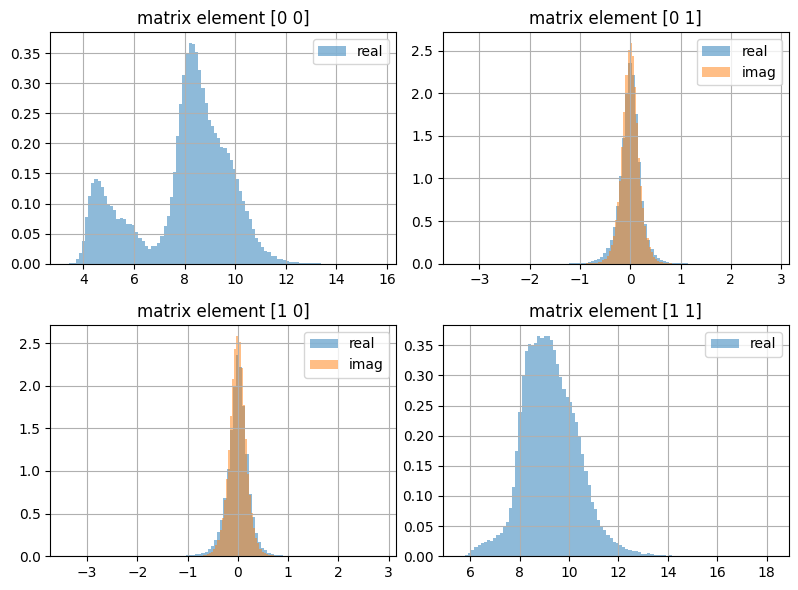

In [78]:
cmap = {0: (0,0), 1: (0,1), 2:(1,0), 3:(1,1)}
for ax,i in subplots(4, n_cols=2, usizex=4):
    my,mx = cmap[i]
    xi = lcm2x2tr[:,:,mx,my].flatten()
    plt.hist(xi.real, alpha=.5, label='real', density=True, bins=100)
    if mx!=my:
        plt.hist(xi.imag, alpha=.5, label='imag', density=True, bins=100)
    plt.grid()
    plt.legend()
    plt.title(f"matrix element [{my} {mx}]")

# visualize histogram of output 3x3 matrix


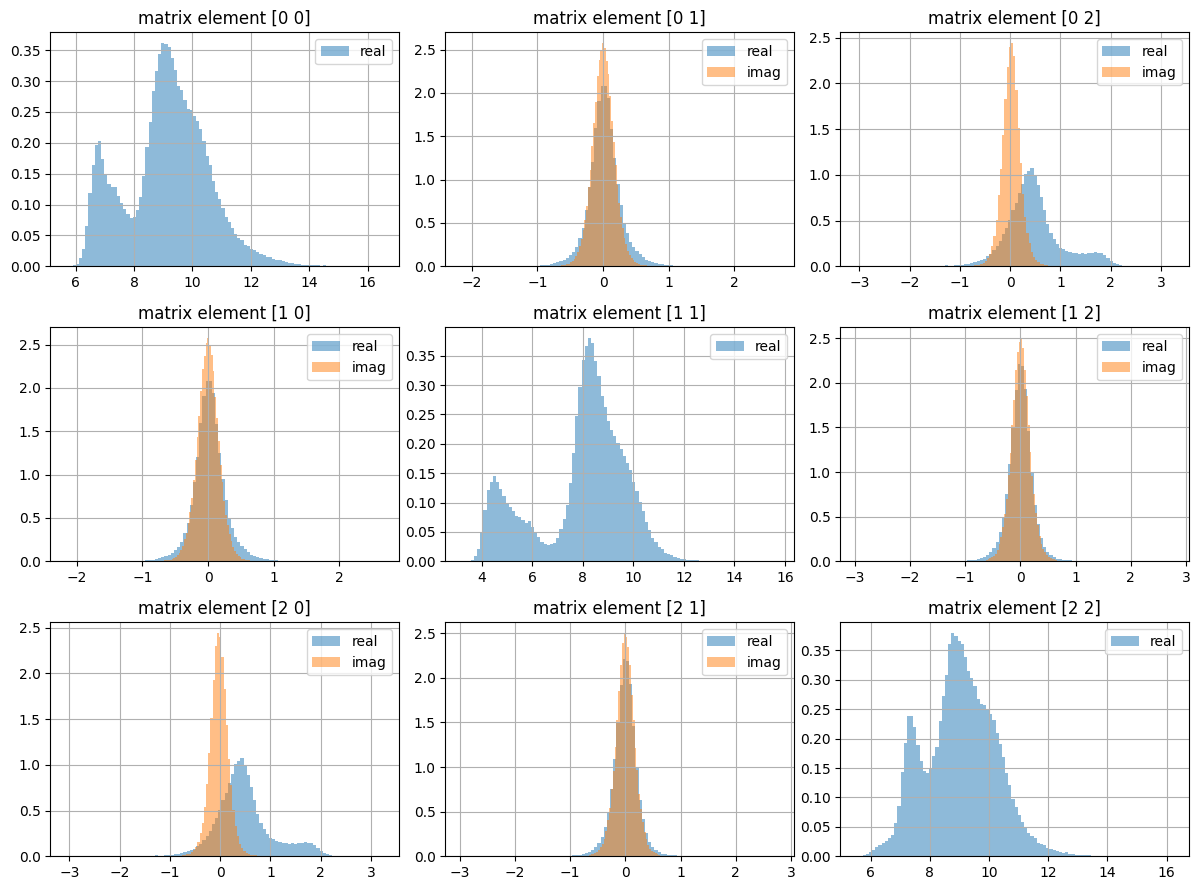

In [79]:
cmap = {0: (0,0), 1: (0,1), 2:(0,2), 3:(1,0), 4:(1,1), 5:(1,2), 6:(2,0), 7:(2,1), 8:(2,2)}
for ax,i in subplots(9, n_cols=3, usizex=4):
    my,mx = cmap[i]
    xi = lcm3x3tr[:,:,mx,my].flatten()
    plt.hist(xi.real, alpha=.5, label='real', density=True, bins=100)
    if mx!=my:
        plt.hist(xi.imag, alpha=.5, label='imag', density=True, bins=100)
    plt.grid()
    plt.legend()
    plt.title(f"matrix element [{my} {mx}]")

# setup data loader

In [547]:
dp = PatchesDataModule(
        input_train_image  = lcm2x2tr,
        output_train_image = lcm3x3tr,
        input_test_image   = lcm2x2ts,
        output_test_image  = lcm3x3ts,
        input_val_image    = lcm2x2ts,
        output_val_image   = lcm3x3ts,
        patch_size  = 10,
        batch_size  = 4,
        splitmask   = splitmask_bands,
        shuffle_train = True,
        shuffle_test  = True,
        shuffle_val   = True
)

2024-04-06 10:31:42.109 | INFO     | lib.datamodules.patches:__init__:52 - PatchesDataset              patch_size=10  splitmask_dims=(628, 228)
original split proportions: train=0.713  test=0.143  val=0.143
patch split proportions:    train=0.710  test=0.109  val=0.182
        


# setup model an optimizer

In [649]:
reload(logmatrixreg1x1)

dtr = dp.train_dataloader()
m = logmatrixreg1x1.Conv1x1LogMatrixRegressor()
optimizer = torch.optim.RMSprop(m.parameters(), lr=1e-3)

complex_rmse_loss_fn = lambda y_true, y_pred: torch.sqrt(torch.mean((y_pred-y_true)*(y_pred-y_true).conj()).real)

nparams = sum([len(p.flatten()) for p in m.parameters()])
print (f"number of model parameters {nparams}")

number of model parameters 2359


# train loop

In [650]:
n_epochs = 10

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dtr):
        # extract data from batch
        x = batch['input_patch']
        t = batch['output_patch']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = complex_rmse_loss_fn(t, o)

        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-10:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 241 loss 0.42374 params 0.3832873
epoch   1 step 241 loss 0.45751 params 0.5805097
epoch   2 step 241 loss 0.35418 params 0.7892647
epoch   3 step 241 loss 0.39729 params 1.0056087
epoch   4 step 241 loss 0.42653 params 1.2317942
epoch   5 step 241 loss 0.40668 params 1.4608535
epoch   6 step 241 loss 0.41602 params 1.6920401
epoch   7 step 241 loss 0.38879 params 1.9291646
epoch   8 step 241 loss 0.42597 params 2.1661296
epoch   9 step 241 loss 0.38952 params 2.3980143


(-0.1, 1.0)

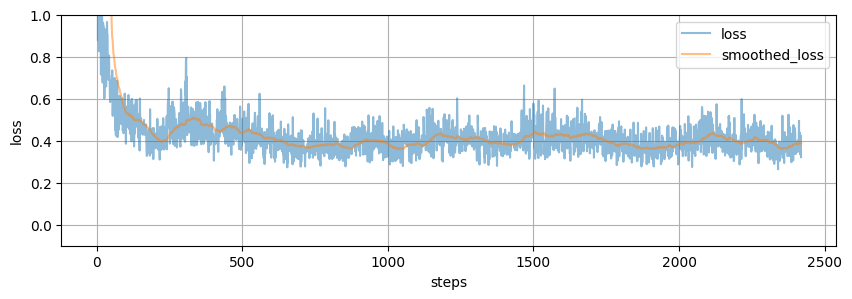

In [651]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
plt.ylim(-0.1,1)


# losses for all datasets

In [652]:
# val and test losses
def dataset_loss(dataloader, loss_fn):
    lossh = []
    for step, batch in pbar(enumerate(dataloader)):
        # extract data from batch
        x = batch['input_patch']
        t = batch['output_patch']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = loss_fn(t, o).detach().cpu().numpy()
        lossh.append(loss)
    return np.mean(lossh)

In [653]:
dataset_loss(dp.train_dataloader(), complex_rmse_loss_fn)

| |             #                                   | 241 Elapsed Time: 0:00:01


0.36762226

In [654]:
dataset_loss(dp.test_dataloader(), complex_rmse_loss_fn)

| |  #                                               | 36 Elapsed Time: 0:00:00


0.36926037

In [655]:
dataset_loss(dp.val_dataloader(), complex_rmse_loss_fn)

| |       #                                          | 61 Elapsed Time: 0:00:00


0.38239446

## stuff I tried

In [ ]:

# splitting loss real and imag (sometimes works)
#loss_real = torch.mean((o.real-t.real)**2)
#loss_imag = torch.mean((o.imag-t.imag)**2)
#loss = loss_real + loss_imag


# these optimizers either do not converge or quicky turn into nans
#optimizer = torch.optim.Adam(m.parameters(), lr=1e-4, amsgrad=True)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-5, momentum=0.9)

